In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.fftpack

import pyrex

## Quick Links

[Working with Signal objects](#signals)

[Antenna Class and Subclasses](#antennas)

[Ice and Earth Models](#models)

[Particle Generation](#particles)

[Ray Tracing](#ray_tracing)

[Full Simulation](#kernel)

<a id="signals"></a>
# Working with Signal Objects

In [2]:
time_array = np.linspace(0, 10)
value_array = np.sin(time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

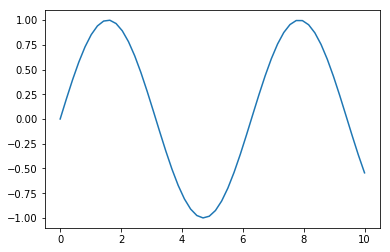

In [3]:
plt.plot(my_signal.times, my_signal.values)
plt.show()

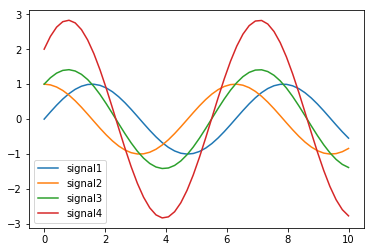

In [4]:
time_array = np.linspace(0, 10)
values1 = np.sin(time_array)
values2 = np.cos(time_array)
signal1 = pyrex.Signal(time_array, values1)
plt.plot(signal1.times, signal1.values, label="signal1")
signal2 = pyrex.Signal(time_array, values2)
plt.plot(signal2.times, signal2.values, label="signal2")
signal3 = signal1 + signal2
plt.plot(signal3.times, signal3.values, label="signal3")
all_signals = [signal1, signal2, signal3]
signal4 = sum(all_signals)
plt.plot(signal4.times, signal4.values, label="signal4")
plt.legend()
plt.show()

In [5]:
print(my_signal.dt == my_signal.times[1] - my_signal.times[0])
print(my_signal.spectrum == scipy.fftpack.fft(my_signal.values))
print(my_signal.frequencies == scipy.fftpack.fftfreq(n=len(my_signal.values), d=my_signal.dt))
print(my_signal.envelope == np.abs(scipy.signal.hilbert(my_signal.values)))

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [6]:
my_signal.resample(1001)
print(len(my_signal.times) == len(my_signal.values) == 1001)
print(my_signal.times[0] == 0)
print(my_signal.times[-1] == 10)

True
True
True


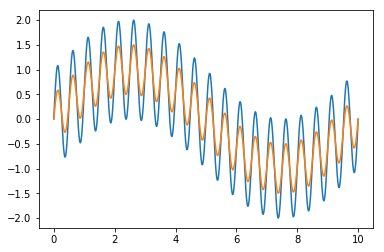

In [7]:
def lowpass_filter(frequency):
    if frequency < 1:
        return 1
    else:
        return 0
    
time_array = np.linspace(0, 10, 1001)
value_array = np.sin(0.1*2*np.pi*time_array) + np.sin(2*2*np.pi*time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

plt.plot(my_signal.times, my_signal.values)
my_signal.filter_frequencies(lowpass_filter)
plt.plot(my_signal.times, my_signal.values)
plt.show()

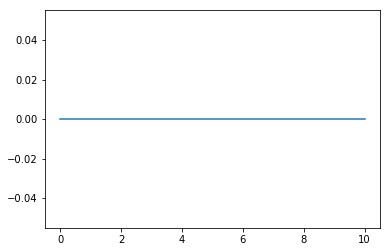

In [8]:
time_array = np.linspace(0,10)
empty = pyrex.EmptySignal(times=time_array)
plt.plot(empty.times, empty.values)
plt.show()

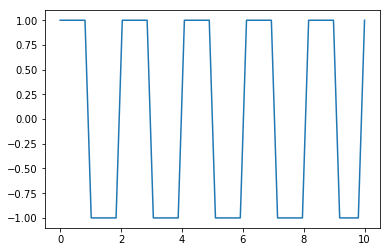

In [9]:
time_array = np.linspace(0,10)
def square_wave(time):
    if int(time)%2==0:
        return 1
    else:
        return -1
square_signal = pyrex.FunctionSignal(times=time_array, function=square_wave)
plt.plot(square_signal.times, square_signal.values)
plt.show()

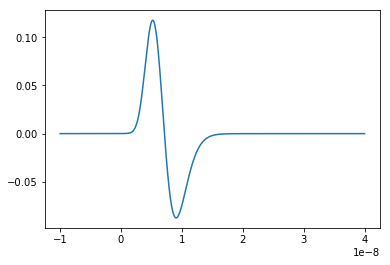

In [10]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
neutrino_energy = 1e8 # GeV
observation_angle = 45 * np.pi/180 # radians
askaryan = pyrex.AskaryanSignal(times=time_array, energy=neutrino_energy, theta=observation_angle)
plt.plot(askaryan.times, askaryan.values)
plt.show()

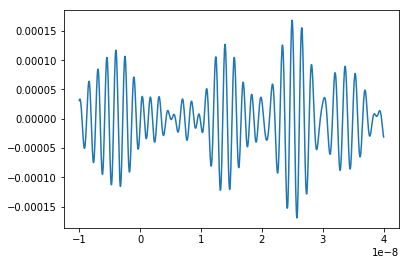

In [11]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
noise_temp = 300 # K
system_resistance = 1000 # ohm
frequency_range = (550e6, 750e6) # Hz
noise = pyrex.ThermalNoise(times=time_array, temperature=noise_temp, resistance=system_resistance, f_band=frequency_range)
plt.plot(noise.times, noise.values)
plt.show()

<a id="antennas"></a>
# Antenna Class and Subclasses

In [12]:
position = (0, 0, -100) # m
temperature = 300 # K
resistance = 1e15 # ohm
frequency_range = (0, 1e3) # Hz
basic_antenna = pyrex.Antenna(position=position, temperature=temperature,
                              resistance=resistance,
                              freq_range=frequency_range)
noiseless_antenna = pyrex.Antenna(position=position, noisy=False)

In [13]:
print(basic_antenna.is_hit == False)
print(basic_antenna.waveforms == [])

True
True


In [14]:
print(basic_antenna.trigger(pyrex.Signal([0],[0])) == True)
freqs = [1, 2, 3, 4, 5]
print(basic_antenna.response(freqs) == [1, 1, 1, 1, 1])

True
[ True  True  True  True  True]


True


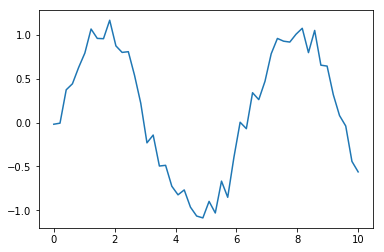

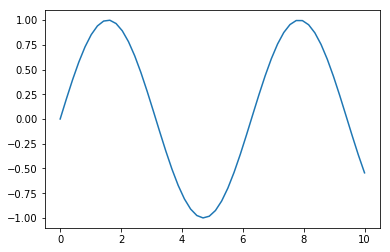

In [15]:
incoming_singal = pyrex.FunctionSignal(np.linspace(0,10), np.sin)
basic_antenna.receive(incoming_singal)
print(basic_antenna.is_hit == True)
for wave in basic_antenna.waveforms:
    plt.figure()
    plt.plot(wave.times, wave.values)
    plt.show()
for pure_signal in basic_antenna.signals:
    plt.figure()
    plt.plot(pure_signal.times, pure_signal.values)
    plt.show()

In [16]:
basic_antenna.clear()
print(basic_antenna.is_hit == False)
print(len(basic_antenna.waveforms) == 0)

True
True


In [17]:
class NoiselessThresholdAntenna(pyrex.Antenna):
    def __init__(self, position, threshold):
        super().__init__(position=position, noisy=False)
        self.threshold = threshold

    def trigger(self, signal):
        if max(np.abs(signal.values)) > self.threshold:
            return True
        else:
            return False

True
True
True
True
True
True


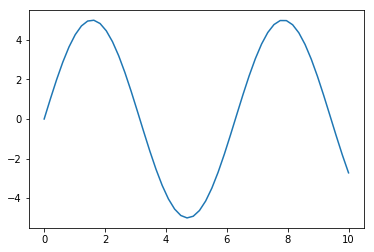

In [18]:
my_antenna = NoiselessThresholdAntenna(position=(0, 0, 0), threshold=2)

incoming_singal = pyrex.FunctionSignal(np.linspace(0,10), np.sin)
my_antenna.receive(incoming_singal)
print(my_antenna.is_hit == False)
print(len(my_antenna.waveforms) == 0)
print(len(my_antenna.all_waveforms) == 1)

incoming_singal = pyrex.Signal(incoming_singal.times,
                               5*incoming_singal.values)
my_antenna.receive(incoming_singal)
print(my_antenna.is_hit == True)
print(len(my_antenna.waveforms) == 1)
print(len(my_antenna.all_waveforms) == 2)

for wave in my_antenna.waveforms:
    plt.figure()
    plt.plot(wave.times, wave.values)
    plt.show()

In [19]:
antenna_identifier = "antenna 1"
position = (0, 0, -100)
center_frequency = 250e6 # Hz
bandwidth = 300e6 # Hz
resistance = 100 # ohm
antenna_length = 3e8/center_frequency/2 # m
polarization_direction = (0, 0, 1)
trigger_threshold = 1e-5 # V
dipole = pyrex.DipoleAntenna(name=antenna_identifier,position=position,
                             center_frequency=center_frequency,
                             bandwidth=bandwidth, resistance=resistance,
                             effective_height=antenna_length,
                             polarization=polarization_direction,
                             trigger_threshold=trigger_threshold)

<a id="models"></a>
# Ice and Earth Models

In [20]:
depth = -1000 # m
print(pyrex.IceModel.temperature(depth))
print(pyrex.IceModel.index(depth))
print(pyrex.IceModel.gradient(depth))
frequency = 1e8 # Hz
print(pyrex.IceModel.attenuation_length(depth, frequency))

226.57523999999998
1.75799918944
[  0.00000000e+00  -1.06994359e-08]
1892.3586992


In [21]:
radius = 6360000 # m
pyrex.prem_density(radius)

2.6

In [22]:
nadir_angle = 60 * np.pi/180 # radians
depth = 1000 # m
pyrex.slant_depth(nadir_angle, depth)

2551914588.6298146

<a id="particles"></a>
# Particle Generation

In [23]:
initial_position = (0,0,0) # m
direction_vector = (0,0,-1)
particle_energy = 1e8 # GeV
pyrex.Particle(vertex=initial_position, direction=direction_vector,
               energy=particle_energy)

Particle(vertex=(0, 0, 0), direction=(0, 0, -1), energy=100000000.0)

In [24]:
box_width = 1000 # m
box_depth = 500 # m
const_energy_generator = lambda: 1e8 # GeV
my_generator = pyrex.ShadowGenerator(dx=box_width, dy=box_width,
                                     dz=box_depth,
                                     energy_generator=const_energy_generator)
my_generator.create_particle()

Particle(vertex=array([ 424.47861547,  255.80996582, -283.79221698]), direction=[0.8405212770912065, 0.030154169774396396, -0.5409387292496113], energy=100000000.0)

<a id="ray_tracing"></a>
# Ray Tracing

In [25]:
start = (0, 0, -100) # m
finish = (0, 0, -250) # m
my_path = pyrex.PathFinder(ice_model=pyrex.IceModel,
                           from_point=start, to_point=finish)

In [26]:
print(my_path.exists)
print(my_path.emitted_ray)
print(my_path.path_length)

True
[ 0.  0. -1.]
150.0


In [27]:
print(my_path.time_of_flight(n_steps=100))
print(my_path.time_of_flight() == my_path.tof)

8.53531869546e-07
True


In [28]:
frequency = 1e9 # Hz
my_path.attenuation(f=frequency, n_steps=100)

0.88924739376307271

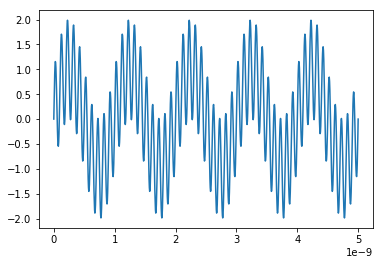

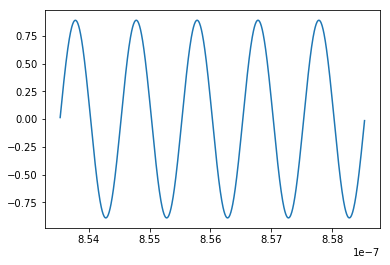

In [29]:
time_array = np.linspace(0, 5e-9, 1001)
my_signal = (pyrex.FunctionSignal(time_array, lambda t: np.sin(1e9*2*np.pi*t))
             + pyrex.FunctionSignal(time_array, lambda t: np.sin(1e10*2*np.pi*t)))
plt.plot(my_signal.times, my_signal.values)
plt.show()

my_path.propagate(my_signal)
plt.plot(my_signal.times, my_signal.values)
plt.show()

<a id="kernel"></a>
# Full Simulation

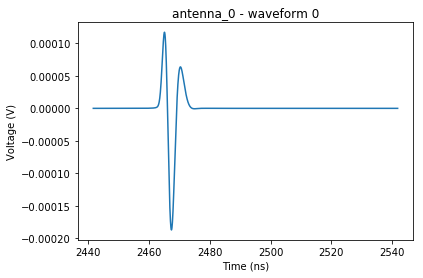

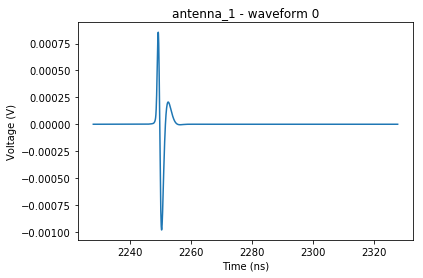

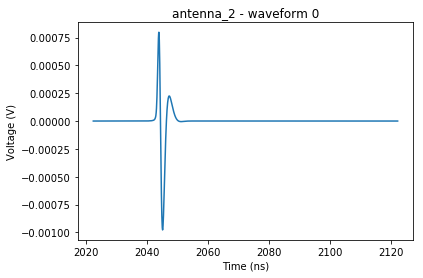

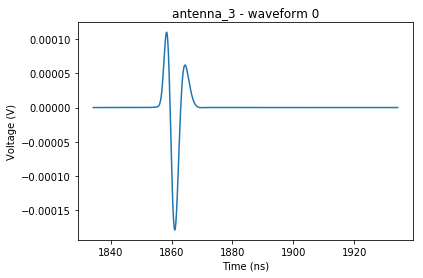

In [30]:
particle_generator = pyrex.ShadowGenerator(dx=1000, dy=1000, dz=500,
                                           energy_generator=lambda: 1e8)
detector = []
for i, z in enumerate([-100, -150, -200, -250]):
    detector.append(
        pyrex.DipoleAntenna(name="antenna_"+str(i), position=(0, 0, z),
                            center_frequency=250e6, bandwidth=300e6,
                            resistance=0, effective_height=0.6,
                            trigger_threshold=0, noisy=False)
    )
kernel = pyrex.EventKernel(generator=particle_generator,
                           ice_model=pyrex.IceModel,
                           antennas=detector)

triggered = False
while not triggered:
    kernel.event()
    for antenna in detector:
        if antenna.is_hit:
            triggered = True
            break

for antenna in detector:
    for i, wave in enumerate(antenna.waveforms):
        plt.plot(wave.times * 1e9, wave.values)
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (V)")
        plt.title(antenna.name + " - waveform "+str(i))
        plt.show()